In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
plt.style.use('seaborn-white')
tfd = tfp.distributions

2024-02-18 12:47:13.790812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/tmp/ipykernel_3547127/4200496385.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
def session_options(enable_gpu_ram_resizing=True):
  """Convenience function which sets common `tf.Session` options."""
  config = tf.ConfigProto()
  config.log_device_placement = True
  if enable_gpu_ram_resizing:
    # `allow_growth=True` makes it possible to connect multiple colabs to your
    # GPU. Otherwise the colab malloc's all GPU ram.
    config.gpu_options.allow_growth = True
  return config

def reset_sess(config=None):
  """Convenience function to create the TF graph and session, or reset them."""
  if config is None:
    config = session_options()
  tf.reset_default_graph()
  global sess
  try:
    sess.close()
  except:
    pass
  sess = tf.InteractiveSession(config=config)


In [3]:
# For reproducibility
rng = np.random.RandomState(seed=45)
tf.set_random_seed(76)

# Precision
dtype = np.float64

# Number of training samples
num_samples = 50000

# Ground truth loc values which we will infer later on. The scale is 1.
true_loc = np.array([[-4, -4],
                     [0, 0],
                     [4, 4]], dtype)

true_components_num, dims = true_loc.shape

# Generate training samples from ground truth loc
true_hidden_component = rng.randint(0, true_components_num, num_samples)
observations = (true_loc[true_hidden_component]
                + rng.randn(num_samples, dims).astype(dtype))


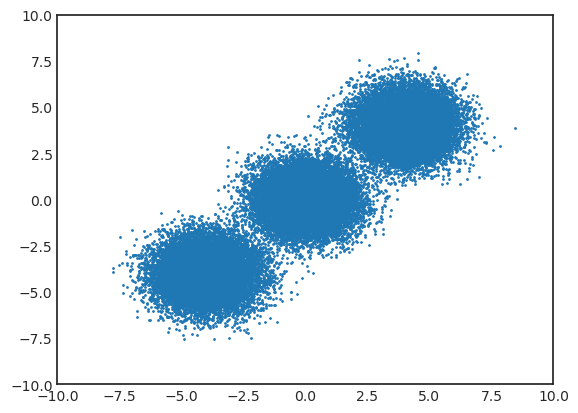

In [4]:
# Visualize samples
plt.scatter(observations[:, 0], observations[:, 1], 1)
plt.axis([-10, 10, -10, 10])
plt.show()


In [5]:
reset_sess()

# Upperbound on K
max_cluster_num = 30

# Define trainable variables.
mix_probs = tf.nn.softmax(
    tf.Variable(
        name='mix_probs',
        initial_value=np.ones([max_cluster_num], dtype) / max_cluster_num))

loc = tf.Variable(
    name='loc',
    initial_value=np.random.uniform(
        low=-9, #set around minimum value of sample value
        high=9, #set around maximum value of sample value
        size=[max_cluster_num, dims]))

precision = tf.nn.softplus(tf.Variable(
    name='precision',
    initial_value=
    np.ones([max_cluster_num, dims], dtype=dtype)))

alpha = tf.nn.softplus(tf.Variable(
    name='alpha',
    initial_value=
    np.ones([1], dtype=dtype)))

training_vals = [mix_probs, alpha, loc, precision]


# Prior distributions of the training variables

#Use symmetric Dirichlet prior as finite approximation of Dirichlet process.
rv_symmetric_dirichlet_process = tfd.Dirichlet(
    concentration=np.ones(max_cluster_num, dtype) * alpha / max_cluster_num,
    name='rv_sdp')

rv_loc = tfd.Independent(
    tfd.Normal(
        loc=tf.zeros([max_cluster_num, dims], dtype=dtype),
        scale=tf.ones([max_cluster_num, dims], dtype=dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_loc')


rv_precision = tfd.Independent(
    tfd.InverseGamma(
        concentration=np.ones([max_cluster_num, dims], dtype),
        scale=np.ones([max_cluster_num, dims], dtype)),
    reinterpreted_batch_ndims=1,
    name='rv_precision')

rv_alpha = tfd.InverseGamma(
    concentration=np.ones([1], dtype=dtype),
    scale=np.ones([1]),
    name='rv_alpha')

# Define mixture model
rv_observations = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=mix_probs),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=loc,
        scale_diag=precision))


Device mapping: no known devices.


In [6]:
# Learning rates and decay
starter_learning_rate = 1e-6
end_learning_rate = 1e-10
decay_steps = 1e4

# Number of training steps
training_steps = 10000

# Mini-batch size
batch_size = 20

# Sample size for parameter posteriors
sample_size = 100

In [7]:
# Placeholder for mini-batch
#observations_tensor = tf.compat.v1.placeholder(dtype, shape=[batch_size, dims])

@tf.function
def logprob_tf_v2(observations_tensor):
    y = rv_observations.log_prob(observations_tensor) / batch_size
    return y

# Define joint log probabilities
# Notice that each prior probability should be divided by num_samples and
# likelihood is divided by batch_size for pSGLD optimization.
log_prob_parts = [
    rv_loc.log_prob(loc) / num_samples,
    rv_precision.log_prob(precision) / num_samples,
    rv_alpha.log_prob(alpha) / num_samples,
    rv_symmetric_dirichlet_process.log_prob(mix_probs)[..., tf.newaxis]
    / num_samples,
    #rv_observations.log_prob(observations_tensor) / batch_size
    logprob_tf_v2(tf.constant(0.1, dtype = dtype, shape = [batch_size, dims]))
]
joint_log_prob = tf.reduce_sum(tf.concat(log_prob_parts, axis=-1), axis=-1)


In [8]:
logprob_tf_v2(tf.constant(0.1, dtype = dtype, shape = [batch_size, dims]))

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([-0.30795452, -0.30795452, -0.30795452, -0.30795452, -0.30795452,
       -0.30795452, -0.30795452, -0.30795452, -0.30795452, -0.30795452,
       -0.30795452, -0.30795452, -0.30795452, -0.30795452, -0.30795452,
       -0.30795452, -0.30795452, -0.30795452, -0.30795452, -0.30795452])>

In [11]:
# Make mini-batch generator
dx = tf.compat.v1.data.Dataset.from_tensor_slices(observations)\
  .shuffle(500).repeat().batch(batch_size)
iterator = tf.compat.v1.data.make_one_shot_iterator(dx)
next_batch = iterator.get_next()

# Define learning rate scheduling
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.polynomial_decay(
    starter_learning_rate,
    global_step, decay_steps,
    end_learning_rate, power=1.)

# Set up the optimizer. Don't forget to set data_size=num_samples.
optimizer_kernel = tfp.optimizer.StochasticGradientLangevinDynamics(
    learning_rate=learning_rate,
    preconditioner_decay_rate=0.99,
    burnin=1500,
    data_size=num_samples)

train_op = optimizer_kernel.minimize(-joint_log_prob)

# Arrays to store samples
mean_mix_probs_mtx = np.zeros([training_steps, max_cluster_num])
mean_alpha_mtx = np.zeros([training_steps, 1])
mean_loc_mtx = np.zeros([training_steps, max_cluster_num, dims])
mean_precision_mtx = np.zeros([training_steps, max_cluster_num, dims])

init = tf.global_variables_initializer()
sess.run(init)

start = time.time()
for it in range(training_steps):
  [
      mean_mix_probs_mtx[it, :],
      mean_alpha_mtx[it, 0],
      mean_loc_mtx[it, :, :],
      mean_precision_mtx[it, :, :],
      _
  ] = sess.run([
      *training_vals,
      train_op
  ], feed_dict={
      observations_tensor: sess.run(next_batch)})

elapsed_time_psgld = time.time() - start
print("Elapsed time: {} seconds".format(elapsed_time_psgld))

# Take mean over the last sample_size iterations
mean_mix_probs_ = mean_mix_probs_mtx[-sample_size:, :].mean(axis=0)
mean_alpha_ = mean_alpha_mtx[-sample_size:, :].mean(axis=0)
mean_loc_ = mean_loc_mtx[-sample_size:, :].mean(axis=0)
mean_precision_ = mean_precision_mtx[-sample_size:, :].mean(axis=0)


AttributeError: module 'tensorflow._api.v2.compat.v2.data' has no attribute 'make_one_shot_iterator'